### Import relevant modules

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from time import time

from dipy.data import fetch_cenir_multib
from dipy.data import read_cenir_multib
from dipy.segment.mask import median_otsu
from dipy.reconst.dti import TensorModel
from dipy.reconst.dki import DiffusionKurtosisModel

from dipy.io.image import load_nifti, save_nifti
from dipy.io.gradients import read_bvals_bvecs
from dipy.core.gradients import gradient_table

from dipy.denoise.localpca import mppca

Denoising code.

In [23]:
from dipy.denoise.localpca import _pca_classifier
from scipy.linalg import eigh

def _hybrid_classifier(L, varest):
    """ Classifies which PCA eigenvalues are related to noise and estimates the
    noise variance

    Parameters
    ----------
    L : array (n,)
        Array containing the PCA eigenvalues in ascending order.
    nvoxels : int
        Number of voxels used to compute L
    varest : float
        Variance prior estimate (if you don't have this you cannot use this method)

    Returns
    -------
    var : float
        Estimation of the noise variance
    ncomps : int
        Number of eigenvalues related to noise

    Notes
    -----
    This is based on the algorithm described in [2]_.
    
    References
    ----------
    .. [2] Henriques et al. Hybrid PCA denoising
    """
    var = np.mean(L)
    c = L.size - 1
    while var > varest:
        var = np.mean(L[:c])
        c = c - 1
    ncomps = c + 1
    return var, ncomps


def genpca(arr, sigma=None, mask=None, patch_radius=2, pca_method='eig',
           tau_factor=None, return_sigma=False, out_dtype=None):
    r"""General function to perform PCA-based denoising of diffusion datasets.

    Parameters
    ----------
    arr : 4D array
        Array of data to be denoised. The dimensions are (X, Y, Z, N), where N
        are the diffusion gradient directions.
    sigma : float or 3D array (optional)
        Standard deviation of the noise estimated from the data. If no sigma
        is given, this will be estimated based on random matrix theory
        [1]_,[2]_
    mask : 3D boolean array (optional)
        A mask with voxels that are true inside the brain and false outside of
        it. The function denoises within the true part and returns zeros
        outside of those voxels.
    patch_radius : int or 1D array (optional)
        The radius of the local patch to be taken around each voxel (in
        voxels). Default: 2 (denoise in blocks of 5x5x5 voxels).
    pca_method : 'eig' or 'svd' (optional)
        Use either eigenvalue decomposition (eig) or singular value
        decomposition (svd) for principal component analysis. The default
        method is 'eig' which is faster. However, occasionally 'svd' might be
        more accurate.
    tau_factor : float (optional)
        If this variable is not None, thresholding of PCA eigenvalues is done
        by nulling out eigenvalues that are smaller than:

        .. math ::

                \tau = (\tau_{factor} \sigma)^2

        \tau_{factor} can be set to a predefined values (e.g. \tau_{factor} =
        2.3 [3]_). In case that the variable is not defined (i.e. in case that \tau_{factor} is set to None),
        tau_factor is calculated according MP-PCA distribution in case that noise variance
        is not give. If noise variance is given, hybrid PCA algorithm is used.
        Default: None.
    return_sigma : bool (optional)
        If true, the Standard deviation of the noise will be returned.
        Default: False.
    out_dtype : str or dtype (optional)
        The dtype for the output array. Default: output has the same dtype as
        the input.

    Returns
    -------
    denoised_arr : 4D array
        This is the denoised array of the same size as that of the input data,
        clipped to non-negative values

    References
    ----------
    .. [1] Veraart J, Novikov DS, Christiaens D, Ades-aron B, Sijbers,
           Fieremans E, 2016. Denoising of Diffusion MRI using random matrix
           theory. Neuroimage 142:394-406.
           doi: 10.1016/j.neuroimage.2016.08.016
    .. [2] Veraart J, Fieremans E, Novikov DS. 2016. Diffusion MRI noise
           mapping using random matrix theory. Magnetic Resonance in Medicine.
           doi: 10.1002/mrm.26059.
    .. [3] Manjon JV, Coupe P, Concha L, Buades A, Collins DL (2013)
           Diffusion Weighted Image Denoising Using Overcomplete Local
           PCA. PLoS ONE 8(9): e73021.
           https://doi.org/10.1371/journal.pone.0073021
    """
    if mask is None:
        # If mask is not specified, use the whole volume
        mask = np.ones_like(arr, dtype=bool)[..., 0]

    if out_dtype is None:
        out_dtype = arr.dtype

    # We retain float64 precision, iff the input is in this precision:
    if arr.dtype == np.float64:
        calc_dtype = np.float64
    # Otherwise, we'll calculate things in float32 (saving memory)
    else:
        calc_dtype = np.float32

    if not arr.ndim == 4:
        raise ValueError("PCA denoising can only be performed on 4D arrays.",
                         arr.shape)

    if pca_method.lower() == 'svd':
        is_svd = True
    elif pca_method.lower() == 'eig':
        is_svd = False
    else:
        raise ValueError("pca_method should be either 'eig' or 'svd'")

    if isinstance(patch_radius, int):
        patch_radius = np.ones(3, dtype=int) * patch_radius
    if len(patch_radius) != 3:
        raise ValueError("patch_radius should have length 3")
    else:
        patch_radius = np.asarray(patch_radius).astype(int)
    patch_size = 2 * patch_radius + 1

    if np.prod(patch_size) < arr.shape[-1]:
        e_s = "You asked for PCA denoising with a "
        e_s += "patch_radius of {0} ".format(patch_radius)
        e_s += "with total patch size of {0}".format(np.prod(patch_size))
        e_s += "for data with {0} directions. ".format(arr.shape[-1])
        e_s += "This would result in an ill-conditioned PCA matrix. "
        e_s += "Please increase the patch_radius."
        raise ValueError(e_s)

    if isinstance(sigma, np.ndarray):
        var = sigma ** 2
        if not sigma.shape == arr.shape[:-1]:
            e_s = "You provided a sigma array with a shape"
            e_s += "{0} for data with".format(sigma.shape)
            e_s += "shape {0}. Please provide a sigma array".format(arr.shape)
            e_s += " that matches the spatial dimensions of the data."
            raise ValueError(e_s)
    elif isinstance(sigma, (int, float)):
        var = sigma ** 2 * np.ones(arr.shape[:-1])

    dim = arr.shape[-1]
    #if tau_factor is None:
    #    tau_factor = 1 + np.sqrt(dim / np.prod(patch_size))

    theta = np.zeros(arr.shape, dtype=calc_dtype)
    thetax = np.zeros(arr.shape, dtype=calc_dtype)
    ncall = np.zeros(arr.shape[:-1], dtype=calc_dtype)

    thetavar = np.zeros(arr.shape[:-1], dtype=calc_dtype)
    if return_sigma is True and sigma is None:
        var = np.zeros(arr.shape[:-1], dtype=calc_dtype)

    # loop around and find the 3D patch for each direction at each pixel
    for k in range(patch_radius[2], arr.shape[2] - patch_radius[2]):
        for j in range(patch_radius[1], arr.shape[1] - patch_radius[1]):
            for i in range(patch_radius[0], arr.shape[0] - patch_radius[0]):
                # Shorthand for indexing variables:
                if not mask[i, j, k]:
                    continue
                ix1 = i - patch_radius[0]
                ix2 = i + patch_radius[0] + 1
                jx1 = j - patch_radius[1]
                jx2 = j + patch_radius[1] + 1
                kx1 = k - patch_radius[2]
                kx2 = k + patch_radius[2] + 1

                X = arr[ix1:ix2, jx1:jx2, kx1:kx2].reshape(
                                np.prod(patch_size), dim)
                # compute the mean and normalize
                M = np.mean(X, axis=0)
                # Upcast the dtype for precision in the SVD
                X = X - M

                if is_svd:
                    # PCA using an SVD
                    U, S, Vt = svd(X, *svd_args)[:3]
                    # Items in S are the eigenvalues, but in ascending order
                    # We invert the order (=> descending), square and normalize
                    # \lambda_i = s_i^2 / n
                    d = S[::-1] ** 2 / X.shape[0]
                    # Rows of Vt are eigenvectors, but also in ascending
                    # eigenvalue order:
                    W = Vt[::-1].T

                else:
                    # PCA using an Eigenvalue decomposition
                    C = np.transpose(X).dot(X)
                    C = C / X.shape[0]
                    [d, W] = eigh(C, turbo=True)

                if sigma is None:
                    # Random matrix theory
                    this_var, ncomps = _pca_classifier(d, np.prod(patch_size))
                else:
                    # Predefined variance
                    this_var = np.mean(var[ix1:ix2, jx1:jx2, kx1:kx2])
                    if tau_factor is None:
                        this_var, ncomps = _hybrid_classifier(d, this_var)
                    else:
                        # tau_factor = 1 + np.sqrt(n / m)
                        tau = tau_factor ** 2 * this_var
                        # Update ncomps according to tau_factor
                        ncomps = np.sum(d < tau)

                W[:, :ncomps] = 0

                # This is equations 1 and 2 in Manjon 2013:
                Xest = X.dot(W).dot(W.T) + M
                Xest = Xest.reshape(patch_size[0],
                                    patch_size[1],
                                    patch_size[2], dim)
                # This is equation 3 in Manjon 2013:
                this_theta = 1.0 / (1.0 + dim - ncomps)
                theta[ix1:ix2, jx1:jx2, kx1:kx2] += this_theta
                thetax[ix1:ix2, jx1:jx2, kx1:kx2] += Xest * this_theta
                ncall[ix1:ix2, jx1:jx2, kx1:kx2] += (dim - ncomps) * this_theta
                thetavar[ix1:ix2, jx1:jx2, kx1:kx2] += this_theta
                
                if return_sigma is True and sigma is None:
                    var[ix1:ix2, jx1:jx2, kx1:kx2] += this_var * this_theta

    denoised_arr = thetax / theta
    denoised_arr.clip(min=0, out=denoised_arr)
    denoised_arr[mask == 0] = 0
    ncall = ncall / thetavar

    if return_sigma is True:
        if sigma is None:
            var = var / thetavar
            var[mask == 0] = 0
            return denoised_arr.astype(out_dtype), np.sqrt(var), ncall
        else:
            return denoised_arr.astype(out_dtype), sigma, ncall
    else:
        return denoised_arr.astype(out_dtype)

## Let's load the data

In [24]:
path = 'D:/Data/Denoising/Dataset3/'

# Dataset 1 - minimized noise spatial correlations
ndata1 = 60
data1, affine = load_nifti(path + 'MB_' + str(ndata1) + '.nii')
mask1, affine = load_nifti(path + 'mask' + str(ndata1) + '.nii')

# Dataset 2 - included acquisitions in EPI ramps and partial fourier
ndata2 = 54
data2, affine = load_nifti(path + 'MB_' + str(ndata2) + '.nii')
mask2, affine = load_nifti(path + 'mask' + str(ndata2) + '.nii')

# b-values are the same for both datasets
bvals, bvecs = read_bvals_bvecs(path + 'MB_' + str(ndata1) + '.bval',
                                path + 'MB_' + str(ndata1) + '.bvec')
gtab = gradient_table(bvals, bvecs)

print('data.shape (%d, %d, %d, %d)' % data1.shape)

data.shape (80, 80, 9, 110)


In [25]:
gtab.bvals

array([   6.293537,    6.293537,    6.293537,    6.293537,    6.293537,
          6.293537,    6.293537,    6.293537,    6.293537,    6.293537,
          6.293537,    6.293537,    6.293537,    6.293537,    6.293537,
          6.293537,    6.293537,    6.293537,    6.293537,    6.293537,
       1004.99    , 2006.121   , 3006.942   , 1003.003   , 2004.217   ,
       3005.148   , 1004.059   , 2004.181   , 3005.104   , 1002.731   ,
       2003.832   , 3004.677   , 1002.703   , 2003.793   , 3004.628   ,
       1002.5     , 2003.504   , 3004.275   , 1002.641   , 2003.705   ,
       3004.521   , 1002.107   , 2002.948   , 3003.595   , 1004.187   ,
       2005.091   , 3005.782   , 1002.144   , 2003.001   , 3003.659   ,
       1002.289   , 2003.207   , 3003.911   , 1003.052   , 2002.887   ,
       3002.883   , 1001.837   , 2002.568   , 3003.128   , 1002.087   ,
       2002.921   , 3003.561   , 1001.6     , 2002.232   , 3002.717   ,
       1002.866   , 2002.977   , 3002.96    , 1001.752   , 2002.

# Estimate noise STD and SNR (dataset1)

In [26]:
S0s = data1[:, :, :, gtab.b0s_mask]
stdS01 = np.std(S0s, axis=-1)
meanS0 = np.mean(S0s, axis=-1)
SNR = meanS0 / stdS01

In [27]:
stdS0_mask = stdS01.copy()
meanS0_mask = meanS0.copy()
stdS0_mask[mask1==0] = 0 
meanS0_mask[mask1==0] = 0 
SNR[mask1==0] = 0 

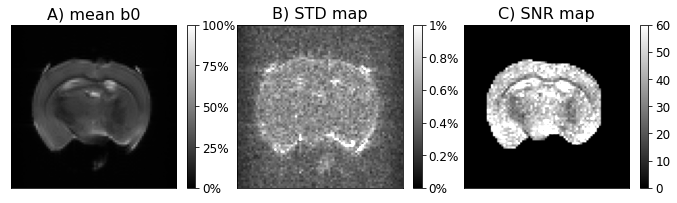

In [28]:
axial_slice = 4
fig1, ax = plt.subplots(1, 3, figsize=(12, 3),
                        subplot_kw={'xticks': [], 'yticks': []})

fig1.subplots_adjust(hspace=0.3, wspace=0.05)
cax = ax.flat[0].imshow(meanS0[:, -1:0:-1, axial_slice].T/np.max(meanS0)*100,
                  origin='lower', cmap='gray',
                  vmin=0, vmax=100)
ax.flat[0].set_title('A) mean b0', fontsize=16)
cbar = plt.colorbar(cax, ax=ax.flat[0], ticks=[0, 25, 50, 75, 100])
cbar.ax.set_yticklabels(['0%', '25%', '50%', '75%', '100%'])
cbar.ax.tick_params(labelsize=12) 

cax = ax.flat[1].imshow(stdS01[:, -1:0:-1, axial_slice].T/np.max(meanS0)*100,
                  origin='lower', cmap='gray',
                  vmin=0, vmax=1)
ax.flat[1].set_title('B) STD map', fontsize=16)
cbar = plt.colorbar(cax, ax=ax.flat[1], ticks=[0, 0.2, 0.4, 0.6, 0.8, 1])
cbar.ax.set_yticklabels(['0%', '0.2%', '0.4%', '0.6%', '0.8%', '1%'])
cbar.ax.tick_params(labelsize=12) 

cax = ax.flat[2].imshow(SNR[:, -1:0:-1, axial_slice].T, origin='lower', cmap='gray',
                  vmin=0, vmax=60)
ax.flat[2].set_title('C) SNR map', fontsize=16)
cbar = plt.colorbar(cax, ax=ax.flat[2])
cbar.ax.tick_params(labelsize=12)

# Denoise data (dataset 1)

In [29]:
t = time()

den_mp1, sig_mp1, nc_mp1 = genpca(data1, patch_radius=[3, 3, 1],
                                        return_sigma=True)

print("Time taken for MP-PCA ", -t + time())

Time taken for MP-PCA  89.06510806083679


In [30]:
t = time()

den_hp1, sig_hp1, nc_hp1 = genpca(data1, patch_radius=[3, 3, 1],
                                  sigma = stdS01, return_sigma=True)

print("Time taken for Hybrid PCA ", -t + time())

Time taken for Hybrid PCA  87.35451602935791


3006.942


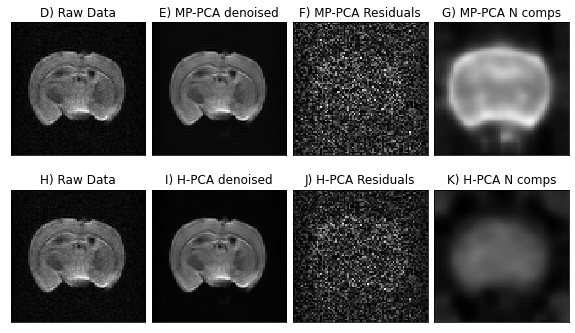

In [32]:
# Gets the center slice and the middle volume of the 4D diffusion data.
sli = axial_slice
gra = 22  # pick out a volume for a high b-value
print(gtab.bvals[gra])

fig1, ax = plt.subplots(2, 4, figsize=(10, 6),
                        subplot_kw={'xticks': [], 'yticks': []})

fig1.subplots_adjust(hspace=0.05, wspace=0.05)

# MP-PCA
orig = data1[:, -1:0:-1, sli, gra]
den = den_mp1[:, -1:0:-1, sli, gra]
nc = nc_mp1[:, -1:0:-1, sli]
# computes the residuals
rms_diff = np.sqrt((orig - den) ** 2)

ax.flat[0].imshow(orig.T, cmap='gray', interpolation='none',
                  origin='lower')
ax.flat[0].set_title('D) Raw Data')
ax.flat[1].imshow(den.T, cmap='gray', interpolation='none',
                  origin='lower')
ax.flat[1].set_title('E) MP-PCA denoised')
ax.flat[2].imshow(rms_diff.T, cmap='gray', interpolation='none',
                  origin='lower')
ax.flat[2].set_title('F) MP-PCA Residuals')
cax = ax.flat[3].imshow(nc.T, cmap='gray', interpolation='none',
                        origin='lower', vmin=0, vmax=20)
ax.flat[3].set_title('G) MP-PCA N comps')

# MP-PCA
orig = data1[:, -1:0:-1, sli, gra]
den = den_hp1[:, -1:0:-1, sli, gra]
nc = nc_hp1[:, -1:0:-1, sli]
# computes the residuals
rms_diff = np.sqrt((orig - den) ** 2)

ax.flat[4].imshow(orig.T, cmap='gray', interpolation='none',
                  origin='lower')
ax.flat[4].set_title('H) Raw Data')
ax.flat[5].imshow(den.T, cmap='gray', interpolation='none',
                  origin='lower')
ax.flat[5].set_title('I) H-PCA denoised')
ax.flat[6].imshow(rms_diff.T, cmap='gray', interpolation='none',
                  origin='lower')
ax.flat[6].set_title('J) H-PCA Residuals')
cax = ax.flat[7].imshow(nc.T, cmap='gray', interpolation='none',
                        origin='lower', vmin=0, vmax=20)
ax.flat[7].set_title('K) H-PCA N comps')

#plt.colorbar(cax)

fig1.savefig('dataset1.png')

# Estimate noise STD and SNR (dataset 2)

In [33]:
S0s = data2[:, :, :, gtab.b0s_mask]
stdS02 = np.std(S0s, axis=-1)
meanS0 = np.mean(S0s, axis=-1)
SNR = meanS0 / stdS02

In [34]:
stdS0_mask = stdS02.copy()
meanS0_mask = meanS0.copy()
stdS0_mask[mask2==0] = 0 
meanS0_mask[mask2==0] = 0 
SNR[mask2==0] = 0 

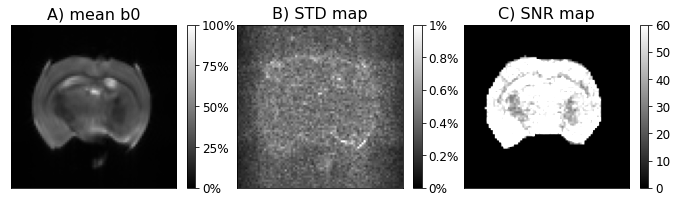

In [35]:
axial_slice = 4
fig1, ax = plt.subplots(1, 3, figsize=(12, 3),
                        subplot_kw={'xticks': [], 'yticks': []})

fig1.subplots_adjust(hspace=0.3, wspace=0.05)
cax = ax.flat[0].imshow(meanS0[:, -1:0:-1, axial_slice].T/np.max(meanS0)*100,
                  origin='lower', cmap='gray',
                  vmin=0, vmax=100)
ax.flat[0].set_title('A) mean b0', fontsize=16)
cbar = plt.colorbar(cax, ax=ax.flat[0], ticks=[0, 25, 50, 75, 100])
cbar.ax.set_yticklabels(['0%', '25%', '50%', '75%', '100%'])
cbar.ax.tick_params(labelsize=12) 

cax = ax.flat[1].imshow(stdS02[:, -1:0:-1, axial_slice].T/np.max(meanS0)*100,
                  origin='lower', cmap='gray',
                  vmin=0, vmax=1)
ax.flat[1].set_title('B) STD map', fontsize=16)
cbar = plt.colorbar(cax, ax=ax.flat[1], ticks=[0, 0.2, 0.4, 0.6, 0.8, 1])
cbar.ax.set_yticklabels(['0%', '0.2%', '0.4%', '0.6%', '0.8%', '1%'])
cbar.ax.tick_params(labelsize=12) 

cax = ax.flat[2].imshow(SNR[:, -1:0:-1, axial_slice].T, origin='lower', cmap='gray',
                  vmin=0, vmax=60)
ax.flat[2].set_title('C) SNR map', fontsize=16)
cbar = plt.colorbar(cax, ax=ax.flat[2])
cbar.ax.tick_params(labelsize=12)

# Denoise data (dataset 2)

In [36]:
t = time()

den_mp2, sig_mp2, nc_mp2 = genpca(data2, patch_radius=[3, 3, 1],
                                  return_sigma=True)

print("Time taken for MP-PCA ", -t + time())

Time taken for MP-PCA  115.60613894462585


In [37]:
t = time()

den_hp2, sig_hp2, nc_hp2 = genpca(data2, patch_radius=[3, 3, 1],
                                  sigma = stdS02, return_sigma=True)

print("Time taken for Hybrid PCA ", -t + time())

Time taken for Hybrid PCA  85.82253432273865


3006.942


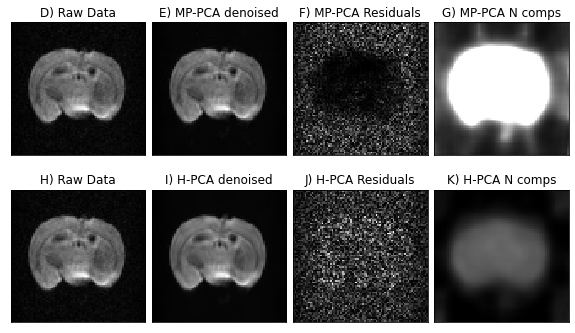

In [39]:
# Gets the center slice and the middle volume of the 4D diffusion data.
sli = axial_slice
gra = 22  # pick out a volume for a high b-value
print(gtab.bvals[gra])

fig1, ax = plt.subplots(2, 4, figsize=(10, 6),
                        subplot_kw={'xticks': [], 'yticks': []})

fig1.subplots_adjust(hspace=0.05, wspace=0.05)

# MP-PCA
orig = data2[:, -1:0:-1, sli, gra]
den = den_mp2[:, -1:0:-1, sli, gra]
nc = nc_mp2[:, -1:0:-1, sli]
# computes the residuals
rms_diff = np.sqrt((orig - den) ** 2)

ax.flat[0].imshow(orig.T, cmap='gray', interpolation='none',
                  origin='lower')
ax.flat[0].set_title('D) Raw Data')
ax.flat[1].imshow(den.T, cmap='gray', interpolation='none',
                  origin='lower')
ax.flat[1].set_title('E) MP-PCA denoised')
ax.flat[2].imshow(rms_diff.T, cmap='gray', interpolation='none',
                  origin='lower')
ax.flat[2].set_title('F) MP-PCA Residuals')
cax = ax.flat[3].imshow(nc.T, cmap='gray', interpolation='none',
                        origin='lower', vmin=0, vmax=20)
ax.flat[3].set_title('G) MP-PCA N comps')

# MP-PCA
orig = data2[:, -1:0:-1, sli, gra]
den = den_hp2[:, -1:0:-1, sli, gra]
nc = nc_hp2[:, -1:0:-1, sli]
# computes the residuals
rms_diff = np.sqrt((orig - den) ** 2)

ax.flat[4].imshow(orig.T, cmap='gray', interpolation='none',
                  origin='lower')
ax.flat[4].set_title('H) Raw Data')
ax.flat[5].imshow(den.T, cmap='gray', interpolation='none',
                  origin='lower')
ax.flat[5].set_title('I) H-PCA denoised')
ax.flat[6].imshow(rms_diff.T, cmap='gray', interpolation='none',
                  origin='lower')
ax.flat[6].set_title('J) H-PCA Residuals')
cax = ax.flat[7].imshow(nc.T, cmap='gray', interpolation='none',
                        origin='lower', vmin=0, vmax=20)
ax.flat[7].set_title('K) H-PCA N comps')

#plt.colorbar(cax)

fig1.savefig('dataset2.png')

# DKI fit

In [40]:
dkim = DiffusionKurtosisModel(gtab)
dki_r1 = dkim.fit(data1, mask=mask1)
dki_r2 = dkim.fit(data2, mask=mask2)
dki_mp1 = dkim.fit(den_mp1, mask=mask1)
dki_mp2 = dkim.fit(den_mp2, mask=mask2)
dki_hp1 = dkim.fit(den_hp1, mask=mask1)
dki_hp2 = dkim.fit(den_hp2, mask=mask2)

In [50]:
# MK
MK1 = dki_r1.mk(0, 10, analytical=False)
MK2 = dki_r2.mk(0, 10, analytical=False)

MK_mp1 = dki_mp1.mk(0, 10, analytical=False)
MK_mp2 = dki_mp2.mk(0, 10, analytical=False) 

MK_hp1 = dki_hp1.mk(0, 10, analytical=False)
MK_hp2 = dki_hp2.mk(0, 10, analytical=False) 

# AK
AK1 = dki_r1.ak(0, 10, analytical=False)
AK2 = dki_r2.ak(0, 10, analytical=False)

AK_mp1 = dki_mp1.ak(0, 10, analytical=False)
AK_mp2 = dki_mp2.ak(0, 10, analytical=False) 

AK_hp1 = dki_hp1.ak(0, 10, analytical=False)
AK_hp2 = dki_hp2.ak(0, 10, analytical=False)

# RK
RK1 = dki_r1.rk(0, 10, analytical=False)
RK2 = dki_r2.rk(0, 10, analytical=False)

RK_mp1 = dki_mp1.rk(0, 10, analytical=False)
RK_mp2 = dki_mp2.rk(0, 10, analytical=False) 

RK_hp1 = dki_hp1.rk(0, 10, analytical=False)
RK_hp2 = dki_hp2.rk(0, 10, analytical=False)

### Plot DKI results for dataset 1

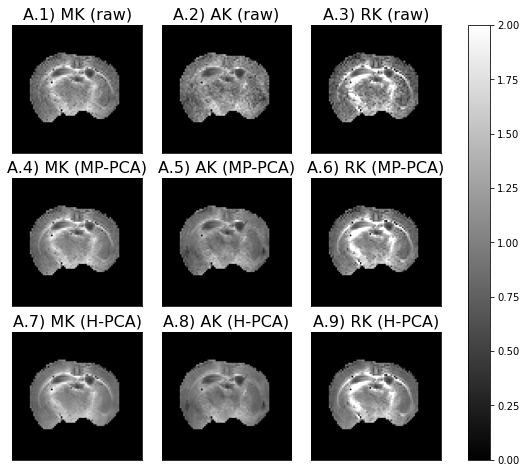

In [51]:
fig2, ax = plt.subplots(3, 3, figsize=(10, 8),
                        subplot_kw={'xticks': [], 'yticks': []})
fig2.subplots_adjust(hspace=0.2, wspace=0.01)

MK =  MK1[:, -1:0:-1, sli]
immk = ax.flat[0].imshow(MK.T, cmap='gray',
                         vmin=0, vmax=2, origin='lower')
ax.flat[0].set_title('A.1) MK (raw)', fontsize=16)


AK =  AK1[:, -1:0:-1, sli]
imak = ax.flat[1].imshow(AK.T, cmap='gray',
                         vmin=0, vmax=2, origin='lower')
ax.flat[1].set_title('A.2) AK (raw)', fontsize=16)
#fig2.colorbar(imak, ax=ax.flat[1])


RK =  RK1[:, -1:0:-1, sli]
imrk = ax.flat[2].imshow(RK.T, cmap='gray',
                         vmin=0, vmax=2, origin='lower')
ax.flat[2].set_title('A.3) RK (raw)', fontsize=16)
#fig2.colorbar(imrk, ax=ax.flat[2])

# MP-PCA
MK =  MK_mp1[:, -1:0:-1, sli]
immk = ax.flat[3].imshow(MK.T, cmap='gray',
                         vmin=0, vmax=2, origin='lower')
ax.flat[3].set_title('A.4) MK (MP-PCA)', fontsize=16)
#fig2.colorbar(immk, ax=ax.flat[3])


AK =  AK_mp1[:, -1:0:-1, sli]
imak = ax.flat[4].imshow(AK.T, cmap='gray',
                         vmin=0, vmax=2, origin='lower')
ax.flat[4].set_title('A.5) AK (MP-PCA)', fontsize=16)
#fig2.colorbar(imak, ax=ax.flat[4])


RK =  RK_mp1[:, -1:0:-1, sli]
imrk = ax.flat[5].imshow(RK.T, cmap='gray',
                         vmin=0, vmax=2, origin='lower')
ax.flat[5].set_title('A.6) RK (MP-PCA)', fontsize=16)
#fig2.colorbar(imrk, ax=ax.flat[5])


# Hybrid
MK =  MK1_hp1[:, -1:0:-1, sli]
immk = ax.flat[6].imshow(MK.T, cmap='gray',
                         vmin=0, vmax=2, origin='lower')
ax.flat[6].set_title('A.7) MK (H-PCA)', fontsize=16)
#fig2.colorbar(immk, ax=ax.flat[6])

AK =  AK_hp1[:, -1:0:-1, sli]
imak = ax.flat[7].imshow(AK.T, cmap='gray',
                         vmin=0, vmax=2, origin='lower')
ax.flat[7].set_title('A.8) AK (H-PCA)', fontsize=16)
#fig2.colorbar(imak, ax=ax.flat[7])


RK =  RK_hp1[:, -1:0:-1, sli]
imrk = ax.flat[8].imshow(RK.T, cmap='gray',
                         vmin=0, vmax=2, origin='lower')
ax.flat[8].set_title('A.9) RK (H-PCA)', fontsize=16)
fig2.colorbar(imrk, ax=ax.flat[:])

### Plot DKI results for dataset 2

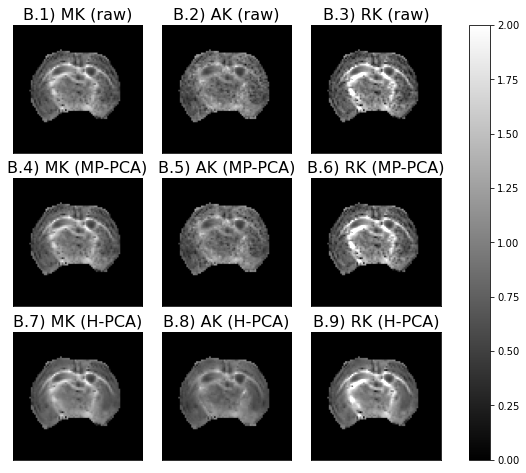

In [54]:
fig2, ax = plt.subplots(3, 3, figsize=(10, 8),
                        subplot_kw={'xticks': [], 'yticks': []})
fig2.subplots_adjust(hspace=0.2, wspace=0.01)

MK =  MK2[:, -1:0:-1, sli]
immk = ax.flat[0].imshow(MK.T, cmap='gray',
                         vmin=0, vmax=2, origin='lower')
ax.flat[0].set_title('B.1) MK (raw)', fontsize=16)


AK =  AK2[:, -1:0:-1, sli]
imak = ax.flat[1].imshow(AK.T, cmap='gray',
                         vmin=0, vmax=2, origin='lower')
ax.flat[1].set_title('B.2) AK (raw)', fontsize=16)
#fig2.colorbar(imak, ax=ax.flat[1])


RK =  RK2[:, -1:0:-1, sli]
imrk = ax.flat[2].imshow(RK.T, cmap='gray',
                         vmin=0, vmax=2, origin='lower')
ax.flat[2].set_title('B.3) RK (raw)', fontsize=16)
#fig2.colorbar(imrk, ax=ax.flat[2])

# MP-PCA
MK =  MK_mp2[:, -1:0:-1, sli]
immk = ax.flat[3].imshow(MK.T, cmap='gray',
                         vmin=0, vmax=2, origin='lower')
ax.flat[3].set_title('B.4) MK (MP-PCA)', fontsize=16)
#fig2.colorbar(immk, ax=ax.flat[3])


AK =  AK_mp2[:, -1:0:-1, sli]
imak = ax.flat[4].imshow(AK.T, cmap='gray',
                         vmin=0, vmax=2, origin='lower')
ax.flat[4].set_title('B.5) AK (MP-PCA)', fontsize=16)
#fig2.colorbar(imak, ax=ax.flat[4])


RK =  RK_mp2[:, -1:0:-1, sli]
imrk = ax.flat[5].imshow(RK.T, cmap='gray',
                         vmin=0, vmax=2, origin='lower')
ax.flat[5].set_title('B.6) RK (MP-PCA)', fontsize=16)
#fig2.colorbar(imrk, ax=ax.flat[5])


# Hybrid
MK =  MK_hp2[:, -1:0:-1, sli]
immk = ax.flat[6].imshow(MK.T, cmap='gray',
                         vmin=0, vmax=2, origin='lower')
ax.flat[6].set_title('B.7) MK (H-PCA)', fontsize=16)
#fig2.colorbar(immk, ax=ax.flat[6])

AK =  AK_hp2[:, -1:0:-1, sli]
imak = ax.flat[7].imshow(AK.T, cmap='gray',
                         vmin=0, vmax=2, origin='lower')
ax.flat[7].set_title('B.8) AK (H-PCA)', fontsize=16)
#fig2.colorbar(imak, ax=ax.flat[7])


RK =  RK_hp2[:, -1:0:-1, sli]
imrk = ax.flat[8].imshow(RK.T, cmap='gray',
                         vmin=0, vmax=2, origin='lower')
ax.flat[8].set_title('B.9) RK (H-PCA)', fontsize=16)
fig2.colorbar(imrk, ax=ax.flat[:])